# Practical 7 - Part 1B
It's time to build something cool! One nice application of homographies is building a simple image stitcher for making panoramas. 

You'll reuse the routines you've written in part 1A (`calcBestHomography` and `solveAXEqualsZero`) again here, so feel free to copy over your functions directly. 

We're provided with three images. One large image, `im1`, is the target, i.e. we'll somehow transform and transfer two other images, `im2` and `im3` into this one.

We need some way of knowing how `im2` and `im3` map into `im1`. To that end, we'll assume a user (or a feature matching alogorithm) provided us with a sets of paired points. One set links points in `im1` to points in `im2`. The other set links `im1` and `im3` in the same manner. To perform the stitch, we'll find two homographies using these point pairs, one to translate between the space in `im1` and the space in `im2` and the other for `im1` and `im3`. 

The end result is worth it, so don't dispair!

## Import libraries 

In [1]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import time

## Loading and plotting images 

Red points show how `im2` and `im1` are related. Magenta points explain how `im1` and `im3` are related.

__NOTE:__ Before you get caught out, notice that the point pairs are in X, Y format, not in R, C format. In this convention, X points run along columns from left to right and Y points run along rows from top to bottom.

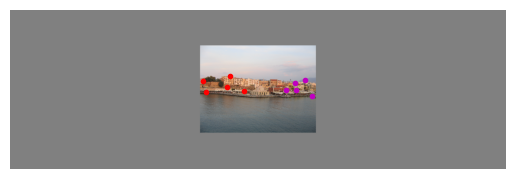

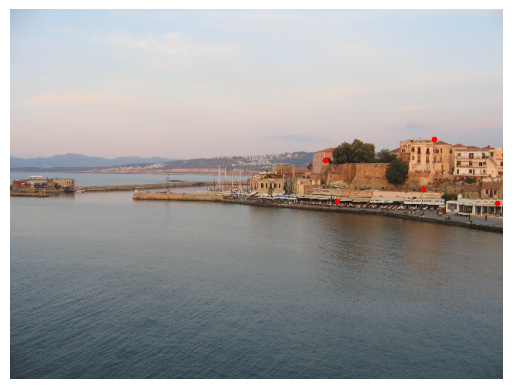

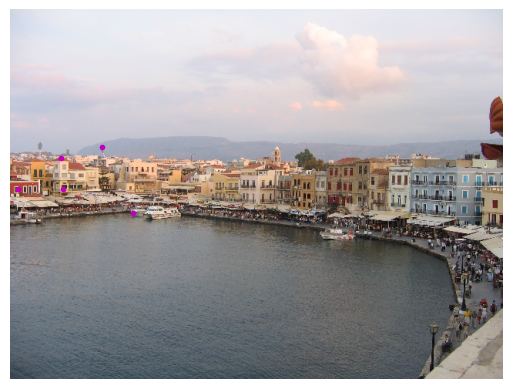

In [2]:
# Load data
data = sio.loadmat('PracticalData.mat', squeeze_me = True);
# Unpack data

# im1 is center image with grey background. im1 has enough space to insert im2 and im3.
im1 = data['im1']

# im2 is left image 
im2 = data['im2']

# pts1 and pts2 are matching points between image1 and image2
pts1 = data['pts1']
pts2 = data['pts2']

# im3 is right image
im3 = data['im3']
# pts1b and pts3 are matching points between image 1 and image 3
pts1b = data['pts1b']
pts3 = data['pts3']

# Show images and points
plt.imshow(im1)
plt.plot(pts1[0,:],pts1[1,:],'r.')
plt.plot(pts1b[0,:],pts1b[1,:],'m.')
plt.axis('off')
plt.show()

plt.imshow(im2)
plt.plot(pts2[0,:],pts2[1,:],'r.')
plt.axis('off')
plt.show()

plt.imshow(im3)
plt.plot(pts3[0,:],pts3[1,:],'m.')
plt.axis('off')
plt.show()

**Figure Comments**:
- **Figure 1**:  
The center image (`im1`) displays matching points with `im2` (red) and `im3` (magenta) clearly marked. The grey background provides ample space for stitching, but the separation of the red and magenta points could introduce slight misalignment errors.

- **Figure 2**:  
The left image (`im2`) shows red points that correspond to points in the center image (`im1`). The points are well-distributed, which is good for robust homography estimation, but their sparse number may limit accuracy.

- **Figure 3**:  
The right image (`im3`) includes magenta points matching those in the center image. While the points are also reasonably well-placed, the dense texture in the background may pose challenges for precise alignment.


## You should copy paste these functions from 1A. Half the work done! 

In [3]:
def solveAXEqualsZero(A):
    # TODO: Write this routine - it should solve Ah = 0. You can do this using SVD. Consult your notes! 
    # Hint: SVD will be involved. 
    """
    Solves the equation A * h = 0 using Singular Value Decomposition (SVD).
    
    Input:
        A (numpy.ndarray): The input matrix A of size (m, n).
    
    Returns:
        h (numpy.ndarray): The solution vector h (the last column of V from SVD).
    """
    # perform SVD on A
    U, S, Vt = np.linalg.svd(A)
    
    # The solution to A * h = 0 is the singular vector corresponding to the smallest singular value
    h = Vt[-1, :] # The last row of Vt (V transposed) corresponds to the smallest singular value
    
    return h

In [4]:
def calcBestHomography(pts1Cart, pts2Cart):
    
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian poitns 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 

    n_points = pts1Cart.shape[1]
    
    # TODO:  replace this:

    # TODO: 
    # First convert points into homogeneous representation
    # Hint: we've done this before  in the skeleton code we provide.
    pts1Hom = np.concatenate((pts1Cart, np.ones((1, n_points))), axis=0) # add a row of ones
    pts2Hom = np.concatenate((pts2Cart, np.ones((1, n_points))), axis=0) 
    
    # TODO: 
    # Then construct the matrix A, size (n_points * 2, 9)
    # Consult the notes!
    # Initialize the A matrix
    n_points = pts1Cart.shape[1]
    A = []
    for i in range(n_points):
        x, y, w = pts1Hom[:, i] # source points in homogeneous coordinates
        x_prime, y_prime, w_prime = pts2Hom[:, i] # destination points in homogeneous coordinates
        
        # construct two rows for the corresponding points (x,y) -> (x',y')
        A.append([x, y, w, 0, 0, 0, -x_prime*x, -x_prime*y, -x_prime])
        A.append([0, 0, 0, x, y, w, -y_prime*x, -y_prime*y, -y_prime])
        
    A = np.array(A)
    # TODO: 
    # Solve Ah = 0 using solveAXEqualsZero and get h.
    h = solveAXEqualsZero(A)
    
    # TODO: 
    # Reshape h into the matrix H, values of h go first into rows of H
    H = np.reshape(h, (3, 3))

    return H

In [5]:
im1.shape
# 880 is the height of the image, 1200 is the width of the image, 3 is the number of channels

(880, 2740, 3)

## The Process

Let's consider the first stitch, transforming and pasting `im2` into `im1`. 

We can loop over every location in `im1` and look in `im2` to see if there's a value we can paste in our image. The act of _looking_ into `im2` means that we need to translate from a location in `im1` to a location in `im2`. You can visualize this easily with the point correspondances already provided. For any other point in `im1`, we need a homography! You can use the function you've written before to generate this homography using `pts1` and `pts2`.

So now that we have a way of going from any location in `im1` to `im2`, we can loop over the locations in `im1`, get the corresponding positions in `im2` using the homography, and copy over that pixel value at each location from `im2` to `im1`.

There's one caveat, it's not always true that a transformed location from `im1` will be a valid index in `im2`, so for every index we need to check if it lies in the bounds of `im2`.

Don't worry if your solution takes a while to run. For loops aren't efficient. It might take anywhere from a minute to three for each stitch. You can make this much faster, but don't worry about that right now. 

Again, careful of how you translate between X-Y and R-C in your code when indexing; you've been warned! 

In [6]:
# TODO:  Calculate homography from pts1 to pts2 
H_1_2 = calcBestHomography(pts1, pts2)

startTime = time.perf_counter()
# TODO: 
# For every pixel in image 1 (two loops):
    # Transform this pixel position with your homography to find where it is in the coordinates of image 2
    # Make sure you round the position using np.round since you'll use it as an index to a matrix.
    # If it the transformed position is within the boundary of image 2: 
    #     Copy pixel colour from image 2 pixel to current position in image 1 

for i in range(im1.shape[0]):
    for j in range(im1.shape[1]): # for every pixel in image 1
        pos = np.array([j, i, 1]) # pixel position in homogeneous coordinates
        pos_prime = np.dot(H_1_2, pos) # transform the pixel position with the homography to find where it is in the coordinates of image 2
        pos_prime = np.round(pos_prime / pos_prime[-1]).astype(int) # round the position using np.round since you'll use it as an index to a matrix
        
        # If the transformed position is within the boundary of image 2
        if 0 <= pos_prime[0] < im2.shape[1] and 0 <= pos_prime[1] < im2.shape[0]: # compare x and y coordinates with the width and height of image 2
            im1[i, j, :] = im2[pos_prime[1], pos_prime[0], :] # copy pixel from image 2 to current position in image 1
            

print("Stitching image 2 to image 1 took: {0:.2f}s".format(time.perf_counter() - startTime))

Stitching image 2 to image 1 took: 18.59s


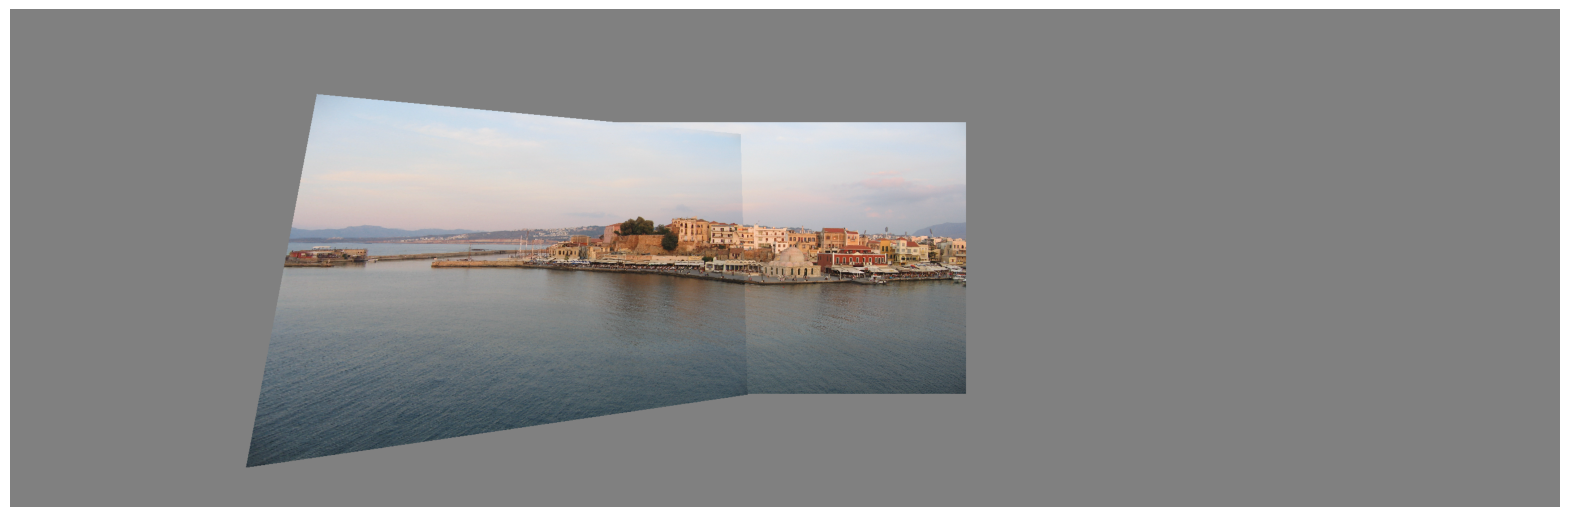

In [7]:
# Plot the intermediate panorama
plt.figure(figsize=(20,20))
plt.imshow(im1)
plt.axis('off')
plt.show()

**Figure Comments**:
- The intermediate panorama shows `im2` (left image) successfully transformed and stitched onto `im1`, aligning the shared regions based on the computed homography.  
- A visible seam is present between the two images due to slight misalignment or lighting differences, which is common in early stitching stages.  
- While the left image transformation appears correct, the perspective distortion indicates that additional post-processing or blending may be needed for smoother transitions.  


In [8]:
# TODO:  Repeat the above process mapping image 3 to image 1.

# Calculate homography from pts1b to pts3
H_1_3 = calcBestHomography(pts1b, pts3)

startTime = time.perf_counter()
for i in range(im1.shape[0]):
    for j in range(im1.shape[1]): # for every pixel in image 1
        pos = np.array([j, i, 1]) # pixel position in homogeneous coordinates
        pos_prime = np.dot(H_1_3, pos) # transform the pixel position with the homography to find where it is in the coordinates of image 2
        pos_prime = np.round(pos_prime / pos_prime[-1]).astype(int) # round the position using np.round since you'll use it as an index to a matrix
        
        # If the transformed position is within the boundary of image 2
        if 0 <= pos_prime[0] < im3.shape[1] and 0 <= pos_prime[1] < im3.shape[0]:
            im1[i, j, :] = im3[pos_prime[1], pos_prime[0], :] # copy pixel from image 3 to current position in image 1
            
# loop and copy pixels...
print("Stitching image 3 to image 1 took: {0:.2f}s".format(time.perf_counter() - startTime))

Stitching image 3 to image 1 took: 18.48s


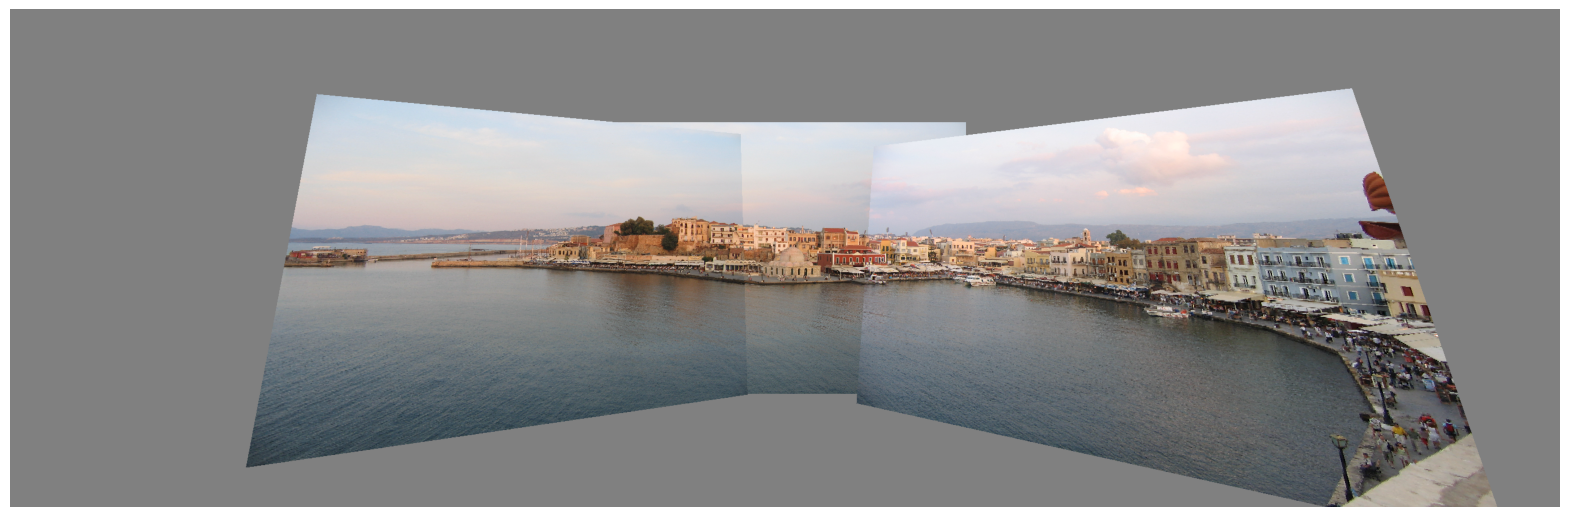

In [9]:
# Plot the final panorama
plt.figure(figsize=(20,20))
plt.imshow(im1)
plt.axis('off')
plt.show()

**Figure Comments**:
- The final panorama shows both `im2` (left) and `im3` (right) stitched onto `im1`, forming a near-complete scene.  
- The seams between the images are still visible, likely due to perspective differences or lighting inconsistencies, which can be improved with blending techniques.  
- The overall alignment is accurate, but slight distortions on the edges and visible perspective warping highlight limitations of homography for wide-angle scenes.

### _Fun_ task for those who have finished all four parts (1A, 1B, 2A, and 2B):

__SPEED__.... I _am_ speed.

Do __NOT__ do this unless you've finished all four parts, want a challenge, and an exercise in numpy and vectorization. 

For loops are slow. Can you think of ways of making it faster with vectorized code? You can definitely bring it down to at least a second per stitch and maybe even lower. Speak to the TAs if you want, but you would need to figure this out for yourself as a good exercise.


### Extrac Task: Numpy Vectorization for Image Stitching

Instead of iterating pixel-by-pixel with nested for-loops, we can leverage NumPy's ability to handle entire arrays at once. This approach is often called "vectorization" and can significantly reduce runtime for large images.

#### Key Steps

1. **Generate a Grid of Pixel Coordinates**  
   Use `np.indices(...)` to get all \((y, x)\) coordinates in the target image (e.g., `im1`) at once.

2. **Convert to Homogeneous Coordinates**  
   Append a row of 1s to each \((x, y)\) coordinate, making them \((x, y, 1)\).

3. **Apply the Homography in One Shot**  
   Multiply by the \(3\times 3\) homography matrix `H_1_2` (or `H_1_3`) to transform all points simultaneously.  
   \[
     \text{pos\_prime} = H \times [x \; y \; 1]^T
   \]

4. **Normalize and Round**  
   Divide by the last coordinate to normalize and then `np.round` to get integer pixel indices.

5. **Mask Out Invalid Coordinates**  
   A coordinate is valid if its mapped \((x', y')\) lies within the source image’s boundaries.

6. **Copy in Bulk**  
   Flatten the target image `im1` into a 2D array (pixel count \(\times\) channels) so we can write all valid pixel mappings in a single assignment.

7. **Reshape Back**  
   Reshape `im1` back to its original dimensions after the assignment.

#### Advantages
- **No Python Loops**: Eliminates slow nested `for` loops over every pixel.  
- **Big Performance Gain**: Exploits fast NumPy operations under the hood.


Stitching image 2 took: 0.29s
Stitching image 3 took: 0.23s


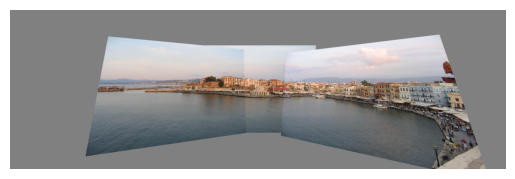

In [10]:
def stitch_image(im1, im2, H):
    """
    Warps im2 onto im1 using the homography H that maps positions in im1 to 
    positions in im2. For each pixel in im1, figure out where it lands in im2,
    and if valid, copy that pixel over from im2.

    This is a vectorized implementation (no explicit Python for-loops).

    Args:
        im1 (np.ndarray): The 'canvas' (destination) image with shape (H1, W1, 3).
        im2 (np.ndarray): The image we are warping into im1, shape (H2, W2, 3).
        H (np.ndarray): 3x3 homography matrix from im1 to im2.

    Returns:
        np.ndarray: The updated im1 (panorama) after stitching im2 onto it.
    """

    # 1) Create a grid of all (y, x) pixel coordinates in im1.
    h, w = im1.shape[:2]
    Y, X = np.indices((h, w))  # Y, X each is (h, w)
    ones = np.ones_like(X)     # same shape as X, Y

    # 2) Flatten and convert to homogeneous coordinates: shape => (3, h*w)
    positions = np.stack((X, Y, ones), axis=-1).reshape(-1, 3).T

    # 3) Apply homography in one shot
    positions_prime = H @ positions

    # Normalize: divide by the last row
    positions_prime /= positions_prime[-1, :]

    # 4) Round and cast to int
    x_prime = np.round(positions_prime[0, :]).astype(int)
    y_prime = np.round(positions_prime[1, :]).astype(int)

    # 5) Build a mask for valid coordinates
    valid_mask = (
        (x_prime >= 0) & (x_prime < im2.shape[1]) &
        (y_prime >= 0) & (y_prime < im2.shape[0])
    )

    # 6) Flatten im1 so we can index it linearly
    im1_flat = im1.reshape(-1, 3)

    # 7) Copy valid pixels from im2 into im1
    im1_flat[valid_mask, :] = im2[y_prime[valid_mask], x_prime[valid_mask], :]

    # 8) Reshape im1 back to original shape
    im1[...] = im1_flat.reshape(h, w, 3)
    return im1


# Usage Example
# Stitch im2
startTime = time.perf_counter()
im1 = stitch_image(im1, im2, H_1_2)
print("Stitching image 2 took: {:.2f}s".format(time.perf_counter() - startTime))

# Stitch im3
startTime = time.perf_counter()
im1 = stitch_image(im1, im3, H_1_3)
print("Stitching image 3 took: {:.2f}s".format(time.perf_counter() - startTime))

# Show the final result
plt.figure()
plt.imshow(im1)
plt.axis('off')
plt.show()